# Tâche 8 : Structure de bande


In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen import Lattice, Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.electronic_structure.plotter import BoltztrapPlotter
from pymatgen.electronic_structure.boltztrap import BoltztrapAnalyzer
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
import matplotlib.pyplot as plt 
import numpy as np
import itertools

In [2]:
with MPRester("P0mh8HMc3qiSX5g1") as m:

    # Bandstructure for material id
    bandstructure = m.get_bandstructure_by_material_id("mp-24504")

# Bande interdite


In [3]:
gap = bandstructure.get_band_gap()
print("Bande interdite directe? " + str(gap['direct']))
print("Energie de la bande interdite : "+str(gap['energy'])+ " eV")
print("Transition de la bande interdite " + str(gap['transition'][1:]) )


Bande interdite directe? False
Energie de la bande interdite : 9.363900000000001 eV
Transition de la bande interdite Gamma-(0.500,0.000,0.393)


Voici les bandes de valence et de conduction avec leur maximum et minimum respectivement


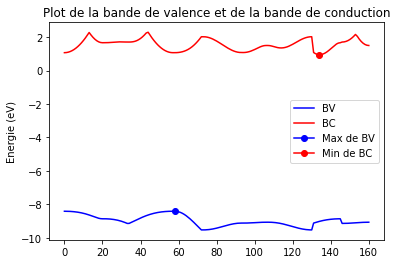

Nous pouvons comparer ce graphe avec celui issu de MaterialsProject reprenant toutes les bandes d'énergie. 
Nous pouvons aussi visualiser les différents chemin de la zone de Brillouin. 


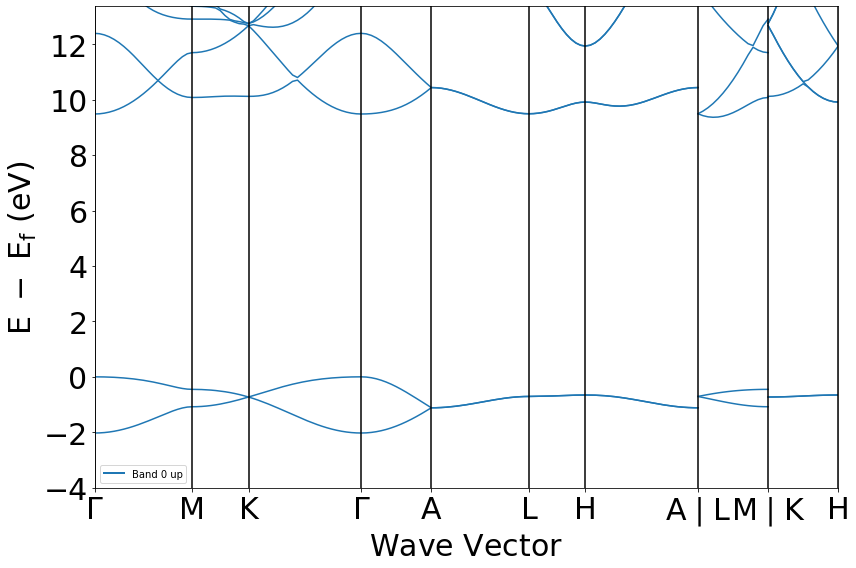

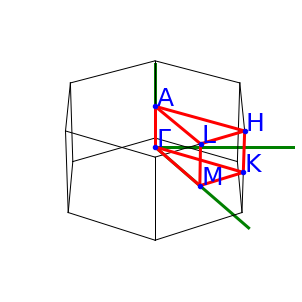

In [4]:
bsplotter = BSPlotter(bandstructure)

data = bsplotter.bs_plot_data()
idxvbm = list(bandstructure.get_vbm()['band_index'].values())[0][0]
idxcbm = list(bandstructure.get_cbm()['band_index'].values())[0][0]

bandvalues = list(bandstructure.bands.values())[0]
BV = bandvalues[idxvbm]
BC = bandvalues[idxcbm]

#Recherche du max de BV et du min de BC
maxBV = [-100000000]
idxmaxBV = [0]
minBC = 100000000
idxminBC = 0
for i in range(len(BC)):
    if(BV[i]>=maxBV):
        maxBV= BV[i]
        idxmaxBV= i

    if(BC[i]<=minBC):
        minBC = BC[i]
        idxminBC = i

        
ks = np.arange(0,len(BC))

print("Voici les bandes de valence et de conduction avec leur maximum et minimum respectivement")
fig, ax = plt.subplots()
ax.plot(ks, BV , 'b', label='BV')
ax.plot(ks, BC,'r' , label='BC')
ax.plot(idxmaxBV, maxBV,'b' ,marker='o', label='Max de BV')
ax.plot(idxminBC, minBC,'r',marker='o',label='Min de BC')
plt.ylabel("Energie (eV)")
plt.title('Plot de la bande de valence et de la bande de conduction')
plt.legend()
plt.show()


print("Nous pouvons comparer ce graphe avec celui issu de MaterialsProject reprenant toutes les bandes d'énergie. ")
print("Nous pouvons aussi visualiser les différents chemin de la zone de Brillouin. ")
bsplotter.get_plot()


bsplotter.plot_brillouin()


# Dispersion

Pour trouver les directions de dispersions maxiamles et minimales nous allons nous baser sur la pente moyenne de chaque chemin individuel. Plus précisément, nous allons calculer la pente entre les extrémités de chaque chemin. Ainsi, nous verrons pour quel chemin la courbure est la plus forte (grande dispersion) et la moins forte (faible dispersion).

In [5]:
distances = data['distances']


E1path = []
E2path = []
for i in range(9) : 
    E1path.append(data['energy']['1'][i][1])
    E2path.append(data['energy']['1'][i][2])

    
dispersions1 = [] 
dispersions2 = []  

for i in range(len(distances)) :
    deltak = abs(distances[i][-1]-distances[i][1])
    dispersions2.append(abs(E2path[i][0]-E2path[i][-1])/deltak)
    dispersions1.append(abs(E1path[i][0]-E1path[i][-1])/deltak)

max1= list(dispersions1).index(max(dispersions1))
min1 = list(dispersions1).index(min(dispersions1))
max2 = list(dispersions2).index(max(dispersions2))
min2 = list(dispersions2).index(min(dispersions2))




print("Pour la bande de valence, la plus grande dispersion se trouve sur le chemin " +str(max1) +" (en orange) et la plus petite dispersion sur le chemin "+str(min1) + " (en vert)")
print("Pour la bande de conduction, la plus grande dispersion se trouve sur le chemin " +str(max2) +" (en orange) et la plus petite dispersion sur le chemin " +str(min2) +" (en vert)")


#Code pour le graphe
#bsplotter.get_plot()
#plt.scatter(distances[max2][0], E2path[max2][0], c='orange')
#plt.scatter(distances[max2][-1], E2path[max2][-1], c='orange')
#plt.scatter(distances[min2][0], E2path[min2][0], c='g')
#plt.scatter(distances[min2][-1], E2path[min2][-1], c='g')
#plt.scatter(distances[max1][0], E1path[max1][0], c='orange')
#plt.scatter(distances[max1][-1], E1path[max1][-1], c='orange')
#plt.scatter(distances[min1][0], E1path[min1][0], c='g')
#plt.scatter(distances[min1][-1], E1path[min1][-1], c='g')
#plt.savefig("dispersion.png")

Pour la bande de valence, la plus grande dispersion se trouve sur le chemin 3 (en orange) et la plus petite dispersion sur le chemin 5 (en vert)
Pour la bande de conduction, la plus grande dispersion se trouve sur le chemin 3 (en orange) et la plus petite dispersion sur le chemin 1 (en vert)


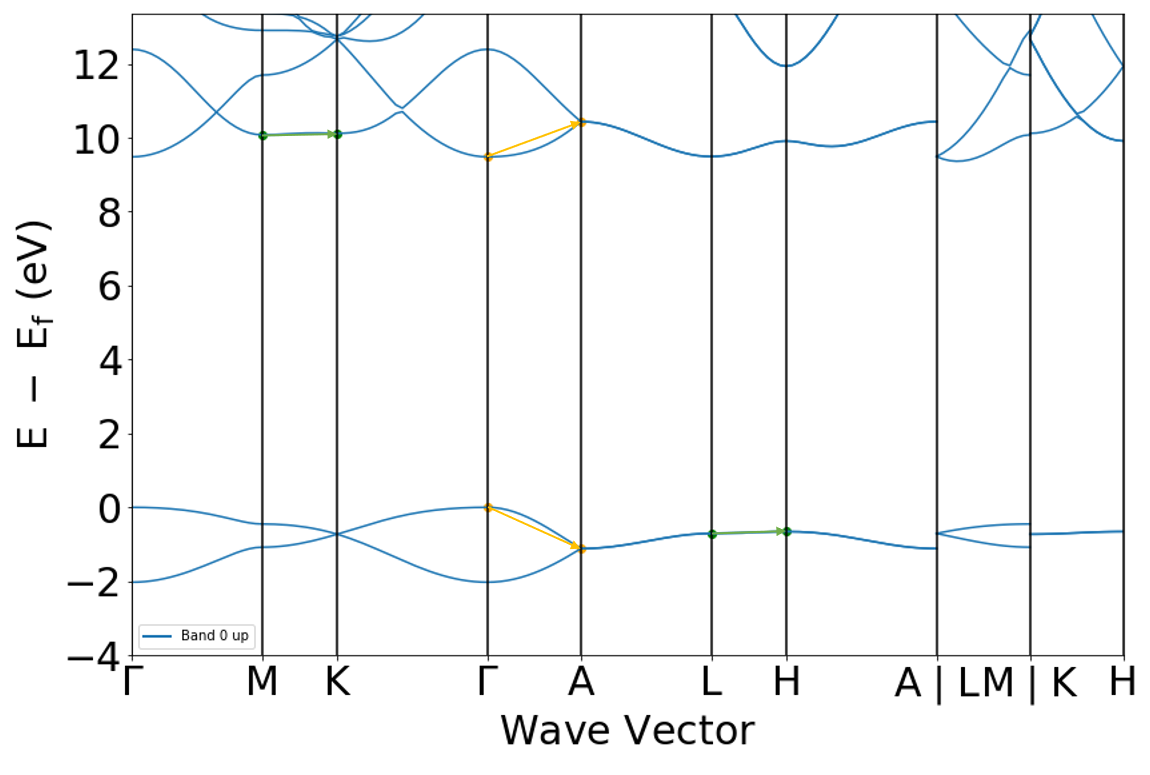


# Masse effective


Nous avons vu dans la partie "Bande interdite" que le maximum de la bande de valence se trouve à l'intersection du chemin 2 et 3 et que le minimum de la bande de conduction se trouve à la première extrémité du chemin 7.

Nous allons approximer la dispersion parabolique locale autour de ces extrema en interpolant 3 points voisins. Ensuite nous pourrons dériver deux fois en fonction de k cette expression pour trouver la masse effective selon la formule:

$m^* = \hbar ^2 \left( \frac{\partial ^2 E}{\partial k^2} \right) ^{-1}$

Pour le maximum de la bande de valence nous prenons des points voisins de par et d'autres du maximum. Pour le minimum de la bande de conduction ce n'était pas possible car le minimu se trouve à un point de discontinuité de la bande. Nous prendrons donc 2 points voisins à droite (direction ou la bande est continue).

In [13]:
#BV
x = [distances[2][-2], distances[2][-1], distances[3][1]]
y = [E1path[2][-2], E1path[2][-1], E1path[3][1]]
interpol = np.polyfit(x,y,2)
m = ((1.054571817*10**(-34))**2)*(1/2*(interpol[0]))*((10**20)*1.60218*10**19)
print("La dispersion parabolique locale autour du maximum de la bande de conduction est d'expression :\nE(k) = "+str(interpol[0])+"k^2 + "+str(interpol[1])+"k + "+str(interpol[2])+" [eV]")
print("La valeur de la masse effective est :  "+str(m)+" [kg]\n")


#BC 
x = [distances[7][0], distances[7][1], distances[7][2]]
y = [E2path[7][0], E2path[7][1], E2path[7][2]]
interpol = np.polyfit(x,y,2)
m = ((1.054571817*10**(-34))**2)*(1/2*(interpol[0]))*((10**20)*1.60218*10**19)
print("La dispersion parabolique locale autour du maximum de la bande de conduction est d'expression :\nE(k) = "+str(interpol[0])+"k^2 + "+str(interpol[1])+"k +"+str(interpol[2])+" [eV]")
print("La valeur de la masse effective est :  "+str(m)+" [kg]\n")


La dispersion parabolique locale autour du maximum de la bande de conduction est d'expression :
E(k) = -1.8207187109286835k^2 + 9.52373276953099k + -12.453413003020593 [eV]
La valeur de la masse effective est :  -1.6220957537775986e-29 [kg]

La dispersion parabolique locale autour du maximum de la bande de conduction est d'expression :
E(k) = 5.431598330970978k^2 + -66.42052132627921k +212.42102129891734 [eV]
La valeur de la masse effective est :  4.839063022755204e-29 [kg]

